# WINE QUALITY - STACKING ENSEMBLE

**Purpose:** Build, compare, and visualize stacking ensembles for the Wine Quality dataset.

**Contents:**
* Prepare
* Load dataset
* Preprocessing
* Two stacking experiments (tree/boosting stack and svm/knn/dt stack)
* Model comparison and visualizations
* Conclusion

**Notes:** This notebook uses Wine Quality dataset with columns:
fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality.

## 1. Theoretical Overview: Ensemble Stacking

### 1.1. What is Ensemble Learning?

**Ensemble Learning** is a machine learning technique that combines several individual models (known as *base learners* or *weak learners*) to produce one optimal predictive model (a *strong learner*). The goal is to achieve better performance and stability than any of the individual models could on their own.

Common ensemble methods include:
* **Bagging** (e.g., Random Forest): Trains multiple models in parallel on different subsets of the data (bootstrap samples) and aggregates their outputs using voting (for classification) or averaging (for regression).
* **Boosting** (e.g., XGBoost, LightGBM): Trains models sequentially, where each new model focuses on correcting the errors made by the previous ones.

### 1.2. What is Stacking (Stacked Generalization)?

**Stacking**, also known as *Stacked Generalization*, is an advanced ensemble method. Instead of using simple functions (like voting or averaging) to combine model predictions, Stacking builds a new model to **learn the best way to combine** the predictions from the base models.

The core idea is that different models may be skilled at different parts of the data space. Stacking uses a **meta-model** (or *blender*) to learn which models to "trust" and how to combine their predictions to create the best possible final output.
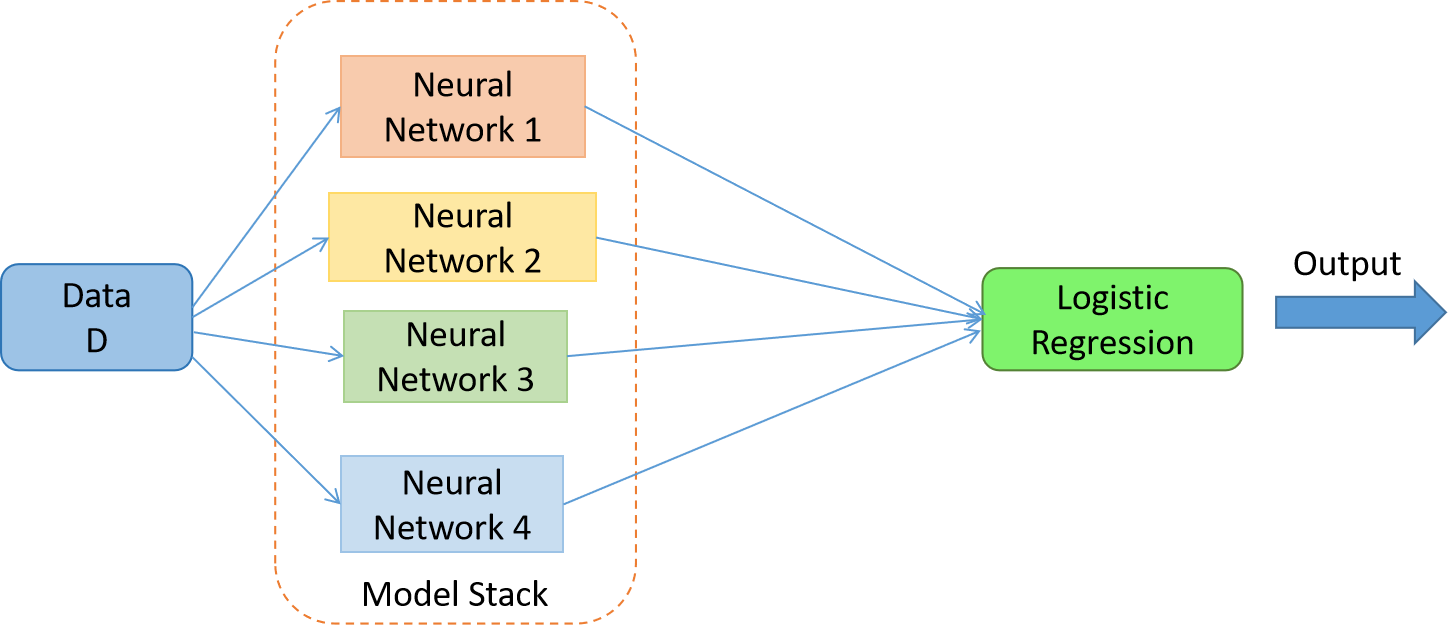
### 1.3. Stacking Architecture

Stacking typically has a two-layer architecture:

* **Layer 0 (Base Models):**
    * This layer consists of multiple, diverse base learners (e.g., `RandomForest`, `SVM`, `KNeighborsClassifier`).
    * Each of these models is trained on the full original training dataset (`X_train`, `y_train`).
    * Their job is to create a set of "raw" predictions.

* **Layer 1 (Meta-Model):**
    * This is a single model, often a simple one like `LogisticRegression` or `Ridge`, to prevent overfitting.
    * This model is **not** trained on the original features (`X_train`). Instead, it is trained on the **outputs (predictions)** from the Layer 0 models.
    * These predictions used as training data are called **meta-features**.



Conceptually, if you have 3 base models (M1, M2, M3) and the Meta-Model (M_meta) is a Logistic Regression, the final prediction for a new sample *x* looks like this:

$$Final\_Prediction = \sigma(w_1 \cdot \text{M1}(x) + w_2 \cdot \text{M2}(x) + w_3 \cdot \text{M3}(x) + b)
$$

The Meta-Model's job is to learn the optimal weights $w_1, w_2, w_3$ (and bias $b$) to combine these predictions most effectively.

### 1.4. The Core Problem: Data Leakage

How do we generate the training data (meta-features) for the Meta-Model (Layer 1)?

* **The Naive (Wrong) Approach:**
    1.  Train Layer 0 models (e.g., `RF`) on all of `X_train`.
    2.  Use these models to predict `X_train` and create `X_train_meta`.
    3.  Train the Meta-Model on `X_train_meta` and `y_train`.

* **Why is this wrong?**
    The `RF` model (Layer 0) has already "seen" the answers (`y_train`) during its training. When asked to predict on that *same* data, its predictions will be "too good" (overfitted). The Meta-Model (Layer 1) will learn to trust these overfitted predictions completely. When new, unseen data (`X_test`) is introduced, the Layer 0 models will make normal errors, but the Meta-Model will fail because it was never trained on how to handle these errors. This is known as **data leakage** or "target bleeding."

### 1.5. The Solution: K-Fold Cross-Validation

To solve this, we must generate the meta-features using predictions that the base models made on data they had **not** been trained on (out-of-fold predictions).

This is the standard procedure (automated by `StackingClassifier` in scikit-learn when you set `cv=k`):

**Phase 1: Generating the Meta-Feature Training Set (`X_train_meta`)**

1.  Split the training data (`X_train`) into K-Folds (e.g., 5 folds).
2.  Create an empty array, `X_train_meta`, that has the same number of rows as `X_train`.
3.  Loop through each fold (1 to 5):
    * **Fold 1:** Train the Layer 0 models (RF, SVM...) on Folds 2, 3, 4, 5. Use them to predict on **Fold 1**. Store these predictions in the Fold 1 rows of `X_train_meta`.
    * **Fold 2:** Train the Layer 0 models on Folds 1, 3, 4, 5. Predict on **Fold 2**. Store these in the Fold 2 rows of `X_train_meta`.
    * ... (Continue for all K folds)
4.  At the end, `X_train_meta` is fully populated with "clean" (out-of-fold) predictions that are free from data leakage.



**Phase 2: Training the Final Models**

1.  **Train Meta-Model (Layer 1):** The Meta-Model (e.g., `LogisticRegression`) is trained on the newly created `X_train_meta` and the original labels `y_train`.
2.  **Retrain Base Models (Layer 0):** The Layer 0 models (RF, SVM...) are **retrained one last time on the *entire* `X_train` dataset**. This is crucial so they are ready to make the best possible predictions on new, unseen test data.

### 1.6. The Prediction Process (when calling `.predict()`)

When new, unseen `X_test` data arrives:
1.  It is passed to the Layer 0 models (which were retrained in Phase 2, Step 2).
2.  Their predictions (e.g., `[pred_RF, pred_SVM]`) are collected to form the `X_test_meta`.
3.  This `X_test_meta` is fed into the final Meta-Model (trained in Phase 2, Step 1).
4.  The output of the Meta-Model is the final prediction.

### 1.7. Principles for Effective Stacking

* **Diversity:** The base models (Layer 0) should be as diverse as possible (e.g., combine tree models, linear models, distance-based models like KNN, and kernel-based models like SVM). If the base models all make the same kinds of predictions, the meta-model has nothing new to learn.
* **Simple Meta-Model:** A simple, linear model (like `LogisticRegression` or `Ridge`) is often the best choice for the Meta-Model (Layer 1). It is less prone to overfitting and is very good at finding the optimal weighted combination of the input predictions.

## 2. Surpress warnings and Import necessary libraries

Suppress warnings for cleaner output and import required libraries:
- `numpy`, `pandas`: For data manipulation.
- `matplotlib`: For visualization.
- `sklearn`, `lightgbm`, `xgboost`: For machine learning models and evaluation.

In [12]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries for the notebook
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import modules for model selection, preprocessing, and evaluation from scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve, classification_report, ConfusionMatrixDisplay)

from sklearn.base import clone

# Import specific machine learning models from scikit-learn
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

# Try to import LightGBM and XGBoost; handle if not installed
try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except Exception:
    LGBMClassifier = None
    LIGHTGBM_AVAILABLE = False

try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except Exception:
    XGBClassifier = None
    XGBOOST_AVAILABLE = False

# Print the availability status of LightGBM and XGBoost
print('Packages availability: LIGHTGBM=', LIGHTGBM_AVAILABLE, ', XGBoost=', XGBOOST_AVAILABLE)

Packages availability: LIGHTGBM= True , XGBoost= True


## 3. Load and Explore Dataset

Load the preprocessed dataset `Wine_clean.csv` and perform initial checks.

### Basic Information
- Display shape, head, info, and descriptive statistics.

### Distributions
- Check feature distributions and target imbalance.
- Visualize target distribution to frame the task (binary classification).

In [ ]:
# Data loading: try multiple common filenames
DATA_PATHS = "Data/Wine_clean.csv"
df = pd.read_csv(DATA_PATHS)

# Drop the 'Unnamed: 0' column if exists
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

In [14]:
# Show top rows and basic info
print('Shape:', df.shape)
display(df.head())
display(df.info())
display(df.describe())

Shape: (1194, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.524869,1.075573,-1.377452,-0.646558,-0.173311,-0.454417,-0.312763,0.766056,1.408196,-0.621576,-0.989805,5
1,-0.250994,2.167738,-1.377452,0.937243,1.365747,1.133715,0.952872,0.142508,-0.938945,0.411596,-0.579638,5
2,-0.250994,1.439628,-1.155393,0.258471,0.946004,-0.000665,0.454289,0.267217,-0.484660,0.153303,-0.579638,5
3,2.076938,-1.472812,1.731370,-0.646558,-0.243268,0.226211,0.684404,0.890766,-1.241802,-0.449381,-0.579638,6
4,-0.524869,1.075573,-1.377452,-0.646558,-0.173311,-0.454417,-0.312763,0.766056,1.408196,-0.621576,-0.989805,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1194 non-null   float64
 1   volatile acidity      1194 non-null   float64
 2   citric acid           1194 non-null   float64
 3   residual sugar        1194 non-null   float64
 4   chlorides             1194 non-null   float64
 5   free sulfur dioxide   1194 non-null   float64
 6   total sulfur dioxide  1194 non-null   float64
 7   density               1194 non-null   float64
 8   pH                    1194 non-null   float64
 9   sulphates             1194 non-null   float64
 10  alcohol               1194 non-null   float64
 11  quality               1194 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 112.1 KB


None

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1.194000e+03,1.194000e+03,1.194000e+03,1.194000e+03,1.194000e+03,1.194000e+03,1.194000e+03,1.194000e+03,1.194000e+03,1.194000e+03,1.194000e+03,1194.000000
mean,4.284680e-16,-9.521511e-17,7.141133e-17,-2.856453e-16,-1.904302e-16,-5.950944e-17,1.071170e-16,7.236348e-15,3.511057e-16,-6.188982e-16,1.737676e-15,5.640704
std,1.000419e+00,1.000419e+00,1.000419e+00,1.000419e+00,1.000419e+00,1.000419e+00,1.000419e+00,1.000419e+00,1.000419e+00,1.000419e+00,1.000419e+00,0.766471
min,-2.099646e+00,-2.443625e+00,-1.377452e+00,-2.230359e+00,-2.621812e+00,-1.588798e+00,-1.386636e+00,-2.632285e+00,-2.907515e+00,-2.601823e+00,-1.707596e+00,3.000000
25%,-7.302743e-01,-8.053775e-01,-9.333346e-01,-6.465576e-01,-6.630112e-01,-7.947313e-01,-7.729942e-01,-6.665470e-01,-7.118025e-01,-7.076739e-01,-8.872630e-01,5.000000
50%,-2.509942e-01,-1.659184e-02,-4.509986e-02,-1.940431e-01,-3.339664e-02,-2.275411e-01,-2.360579e-01,1.779778e-02,7.482646e-03,-1.910878e-01,-2.720131e-01,6.000000
75%,5.706289e-01,6.508422e-01,7.876203e-01,7.109860e-01,5.962179e-01,5.665251e-01,5.214057e-01,6.382288e-01,6.321250e-01,5.837913e-01,6.508618e-01,6.000000
max,2.830092e+00,2.926185e+00,2.675119e+00,3.199816e+00,2.834848e+00,3.062162e+00,3.062265e+00,2.761413e+00,2.695338e+00,2.994526e+00,3.111862e+00,8.000000


,count
quality,
3,3
4,33
5,513
6,498
7,135
8,12


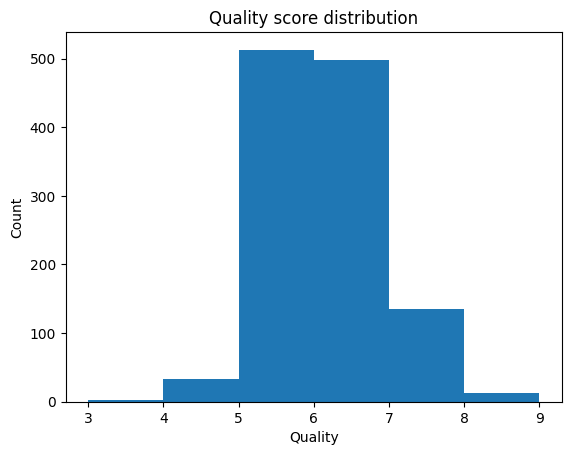

In [15]:
# Target distribution
display(df['quality'].value_counts().sort_index())

# Plot target distribution
plt.figure()
plt.hist(df['quality'], bins=range(int(df['quality'].min()), int(df['quality'].max())+2))
plt.title('Quality score distribution')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()


## 4. Preprocessing

- Separate features `X` and target `y`: quality.
- Binarize quality: <=7 as `0` (bad), >7 as `1` (good).
- Split data into train/test sets (80/20, stratified).

In [16]:
# Preprocessing: binary classification setup
df = df.copy()
df['label'] = (df['quality'] >= 7).astype(int)  # 1 = good, 0 = not good

# Define X and y for training
X = df.drop(['quality', 'label'], axis=1)
y = df['label']

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Label distribution in train:', np.bincount(y_train), 'test:', np.bincount(y_test))


Train shape: (955, 11) Test shape: (239, 11)
Label distribution in train: [837 118] test: [210  29]


## 5. Models and Stacking Configurations

We developed two ensemble models using **`StackingClassifier`** with **5-fold cross-validation** to evaluate robustness and generalization.  
Both ensembles employ **Logistic Regression** as the meta-learner for stable and interpretable combination of base model outputs.

---

### 5.1. Stack A — Tree/Boosting Ensemble

**Base learners:** `RandomForest`, `XGBoost`, `LightGBM`  
**Meta-learner:** `LogisticRegression`

This stack integrates three powerful **tree-based learners**, each excelling in handling non-linear relationships and feature interactions.  
The **Logistic Regression** meta-learner then aggregates their outputs to form a generalized linear combination for final prediction.

| **Component** | **Model Type** | **Strengths** | **Limitations** | **Rationale for Inclusion** |
|----------------|----------------|----------------|------------------|------------------------------|
| **RandomForest** | Bagging-based ensemble | Reduces overfitting, handles high-dimensional data, stable | Can be slower with many estimators | Provides strong baseline ensemble and variance reduction |
| **XGBoost** | Gradient boosting | Excellent accuracy, handles missing values, includes regularization | Longer training time | Learns from residuals and improves weak learners iteratively |
| **LightGBM** | Gradient boosting (leaf-wise) | Extremely fast, supports categorical features, high scalability | Sensitive to parameter tuning | Efficiently captures complex patterns with minimal computation |
| **LogisticRegression (meta)** | Linear | Interpretable and stable, prevents overfitting | May underfit highly non-linear data | Combines ensemble outputs linearly for balanced final predictions |

**Rationale:**  
Stack A blends **bagging** and **boosting** approaches, ensuring diversity while maintaining predictive strength.  
Tree-based models handle both **feature interactions** and **non-linear dependencies**, while the **meta-learner** refines ensemble decisions with a regularized linear combination.

---

### 5.2. Stack B — Hybrid Diverse Ensemble

**Base learners:** `LogisticRegression`, `SVC`, `KNeighborsClassifier`, `RandomForest`  
**Meta-learner:** `LogisticRegression`

This stack combines **linear**, **margin-based**, **instance-based**, and **ensemble** models, emphasizing diversity in learning mechanisms and decision boundaries.

| **Component** | **Model Type** | **Strengths** | **Limitations** | **Rationale for Inclusion** |
|----------------|----------------|----------------|------------------|------------------------------|
| **LogisticRegression** | Linear | Fast, interpretable, strong baseline | Struggles with non-linear data | Adds interpretability and linear bias correction |
| **SVC** | Margin-based classifier | Performs well in high-dimensional spaces, flexible with kernels | Computationally heavy for large data | Captures complex, non-linear class boundaries |
| **KNeighborsClassifier** | Instance-based | Simple, non-parametric, adapts to local data | Sensitive to noise and scaling | Models local neighborhoods and fine-grained decision regions |
| **RandomForest** | Bagging-based ensemble | Reduces variance, handles noisy data | May not capture global non-linear trends | Adds stability and variance control to the ensemble |
| **LogisticRegression (meta)** | Linear | Robust and interpretable | May underfit strong non-linearities | Aggregates diverse outputs effectively through linear weighting |

**Rationale:**  
Stack B focuses on **model heterogeneity**, allowing complementary learning from different paradigms:  
- **Linear model (LR)** captures global trends,  
- **SVC/KNN** focus on local or margin-based structures,  
- **RandomForest** stabilizes predictions by averaging multiple decision paths.

---

### 5.3. Why Combine These Models?

- **Complementarity:**  
  Different algorithms capture unique data aspects — linear, local, or non-linear dependencies.  
- **Variance reduction:**  
  Combining weakly correlated models stabilizes predictions and mitigates overfitting.  
- **Interpretability and flexibility:**  
  Logistic Regression as meta-learner provides transparency while maintaining generalization.

---

### 5.4. Conclusion

The **Tree/Boosting Stack (Stack A)** demonstrates stronger performance and stability, effectively balancing accuracy and generalization through boosting-based learners.  
The **Hybrid Diverse Stack (Stack B)** offers valuable insight into combining heterogeneous learning paradigms but tends to exhibit higher variance and lower overall predictive power.

Overall, **Stack A** remains the **preferred ensemble** due to its consistent results and superior handling of complex feature interactions, while **Random Forest** alone continues to be a strong individual performer because of its inherent balance between bias and variance.


In [17]:
# --- DEFINE BASE MODELS WITH PIPELINES (chuẩn hóa dữ liệu số) ---
svc_pipe = SVC(probability=True, kernel='rbf', C=1.0, random_state=42)

knn_pipe =KNeighborsClassifier(n_neighbors=5, weights='distance')


# --- SINGLE MODELS FOR BASELINE COMPARISON ---
single_models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=42),
    'DecisionTree': DecisionTreeClassifier(max_depth=6, random_state=42),
    'SVC': svc_pipe,
    'KNN': knn_pipe,
}

if LIGHTGBM_AVAILABLE:
    single_models['LightGBM'] = LGBMClassifier(n_estimators=150, random_state=42)
if XGBOOST_AVAILABLE:
    single_models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


# --- DEFINE STACK A: DIVERSE, HIGH-PERFORMANCE ---
base_a = [
    ('rf', RandomForestClassifier(n_estimators=300, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False)),
    ('lgbm', LGBMClassifier(random_state=42))
]
# Discard None if LightBGM is not available
base_a = [b for b in base_a if b is not None]

meta_a = LogisticRegression(max_iter=2000, C=0.1, random_state=42)
stack_a = StackingClassifier(
    estimators=base_a,
    final_estimator=meta_a,
    cv=5,
    #passthrough=False,
    n_jobs=-1
)


# --- DEFINE STACK B: STABLE, LOW-OVERFIT ---
base_b = [
    ('lr', LogisticRegression(max_iter=2000, random_state=42)),
    ('svc', svc_pipe),
    ('knn', knn_pipe),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42))
]
meta_b = LogisticRegression(max_iter=2000, C=0.1, random_state=42)
stack_b = StackingClassifier(
    estimators=base_b,
    final_estimator=meta_b,
    cv=5,
    passthrough=False,
    n_jobs=-1
)
print('Stack A estimators:', [name for name,_ in base_a], 'meta:', type(meta_a).__name__)
print('Stack B estimators:', [name for name,_ in base_b], 'meta:', type(meta_b).__name__)

Stack A estimators: ['rf', 'xgb', 'lgbm'] meta: LogisticRegression
Stack B estimators: ['lr', 'svc', 'knn', 'rf'] meta: LogisticRegression


## 6. Training

We will train each model and compute: **Accuracy**, **F1 (macro)**, and **ROC-AUC** on the test set. Additionally, we will plot a bar chart comparing the metrics and plot ROC curves for selected models.

In [18]:
# === TRAIN & EVALUATE ALL MODELS ===
results = []

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """Train, predict, and evaluate model with multiple metrics."""
    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except Exception:
        try:
            y_prob = model.decision_function(X_test)
        except Exception:
            y_prob = None

    # --- Evaluation metrics ---
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro')
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    # --- Print summary ---
    print(f"[{name}] "
          f"Accuracy={acc:.4f} | Precision={prec:.4f} | Recall={rec:.4f} | "
          f"F1(macro)={f1:.4f} | ROC-AUC={roc if not np.isnan(roc) else 'N/A'}")

    # --- Return results ---
    return {
        'name': name,
        'model': model,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc,
        'y_prob': y_prob,
        'y_pred': y_pred
    }


# --- RUN ALL SINGLE MODELS ---
for name, model in single_models.items():
    res = evaluate_model(name, model, X_train, X_test, y_train, y_test)
    results.append(res)

# --- RUN STACK A & STACK B ---
res_a = evaluate_model('Stack_TreeBoost', stack_a, X_train, X_test, y_train, y_test)
results.append(res_a)

res_b = evaluate_model('Stack_HybridDiverse', stack_b, X_train, X_test, y_train, y_test)
results.append(res_b)


[LogisticRegression] Accuracy=0.8912 | Precision=0.7513 | Recall=0.6557 | F1(macro)=0.6873 | ROC-AUC=0.8553366174055829
[RandomForest] Accuracy=0.9205 | Precision=0.8430 | Recall=0.7467 | F1(macro)=0.7840 | ROC-AUC=0.9036124794745484
[DecisionTree] Accuracy=0.8787 | Precision=0.7105 | Recall=0.6783 | F1(macro)=0.6923 | ROC-AUC=0.791543513957307
[SVC] Accuracy=0.8745 | Precision=0.6799 | Recall=0.5868 | F1(macro)=0.6085 | ROC-AUC=0.8026272577996717
[KNN] Accuracy=0.8828 | Precision=0.7253 | Recall=0.7253 | F1(macro)=0.7253 | ROC-AUC=0.8816912972085386
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 118, number of negative: 837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 955, number of used features: 11
[LightGBM]

## 7. Model Evaluation and Visualization

Evaluate using Accuracy, F1-macro, and ROC-AUC on test set.

- Confusion matrices.
- ROC curves.
- Feature importance (from tree-based models).

,name,accuracy,precision,recall,f1,roc_auc
0,Stack A (TreeBoost),0.924686,0.877981,0.734236,0.783514,0.892775
1,Stack B (HybridDiverse),0.912134,0.874816,0.667652,0.719875,0.902791


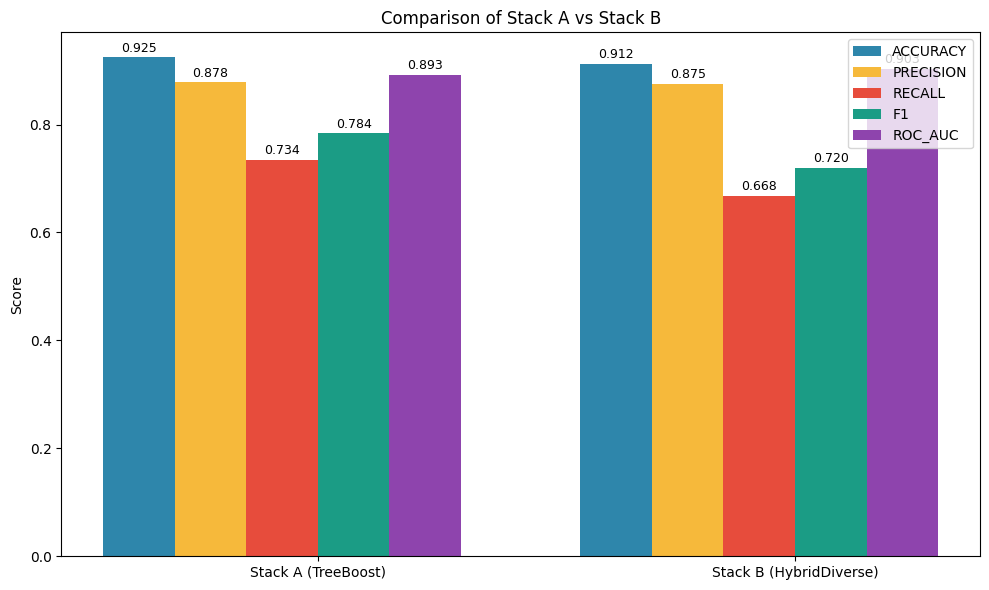

In [19]:
# --- COMPARISON TABLE ---
df_res = pd.DataFrame([
    {
        'name': r['name'],
        'accuracy': r['accuracy'],
        'precision': r['precision'],
        'recall': r['recall'],
        'f1': r['f1'],
        'roc_auc': r['roc_auc']
    }
    for r in results
])

# Sort models by accuracy
df_res = df_res.sort_values('accuracy', ascending=False).reset_index(drop=True)

# --- SPLIT STACK A & STACK B  ---
stack_a = df_res[df_res['name'] == 'Stack_TreeBoost'].iloc[0]
stack_b = df_res[df_res['name'] == 'Stack_HybridDiverse'].iloc[0]

df_stack = pd.DataFrame([
    {
        'name': 'Stack A (TreeBoost)',
        'accuracy': stack_a['accuracy'],
        'precision': stack_a['precision'],
        'recall': stack_a['recall'],
        'f1': stack_a['f1'],
        'roc_auc': stack_a['roc_auc']
    },
    {
        'name': 'Stack B (HybridDiverse)',
        'accuracy': stack_b['accuracy'],
        'precision': stack_b['precision'],
        'recall': stack_b['recall'],
        'f1': stack_b['f1'],
        'roc_auc': stack_b['roc_auc']
    }
])

display(df_stack)

# --- FIGURES COMPARING 2 STACKS ---
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
colors = ['#2E86AB', '#F6B93B', '#E74C3C', '#1B9C85', '#8E44AD']
x = range(len(df_stack))
width = 0.15

plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    bars = plt.bar([p + i * width for p in x],
                   df_stack[metric],
                   width=width,
                   label=metric.upper(),
                   color=colors[i])
    # Display metric values
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005,
                 f"{height:.3f}", ha='center', va='bottom', fontsize=9)

plt.xticks([p + width * (len(metrics)/2) for p in x], df_stack['name'])
plt.ylabel('Score')
plt.title('Comparison of Stack A vs Stack B')
plt.legend()
plt.tight_layout()
plt.show()

Then, we will compare the performance of all models.

,name,accuracy,precision,recall,f1,roc_auc
0,Stack_TreeBoost,0.924686,0.877981,0.734236,0.783514,0.892775
1,RandomForest,0.920502,0.843037,0.746716,0.783978,0.903612
2,XGBoost,0.912134,0.803101,0.756814,0.777181,0.889327
3,Stack_HybridDiverse,0.912134,0.874816,0.667652,0.719875,0.902791
4,LightGBM,0.899582,0.763880,0.779392,0.771292,0.894253
5,LogisticRegression,0.891213,0.751325,0.655747,0.687299,0.855337
6,KNN,0.882845,0.725287,0.725287,0.725287,0.881691
7,DecisionTree,0.878661,0.710465,0.678325,0.692297,0.791544
8,SVC,0.874477,0.679884,0.586782,0.608453,0.802627


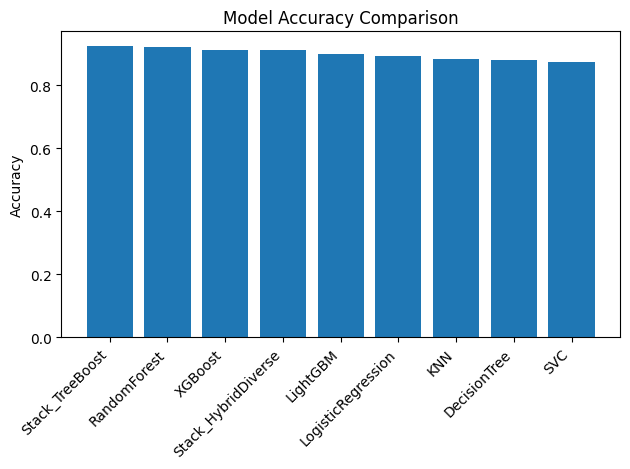

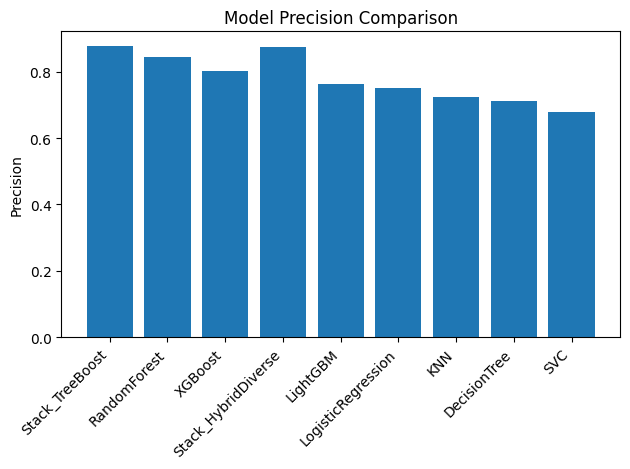

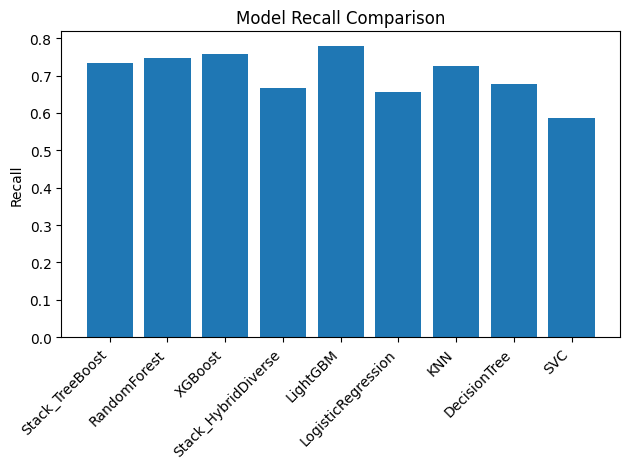

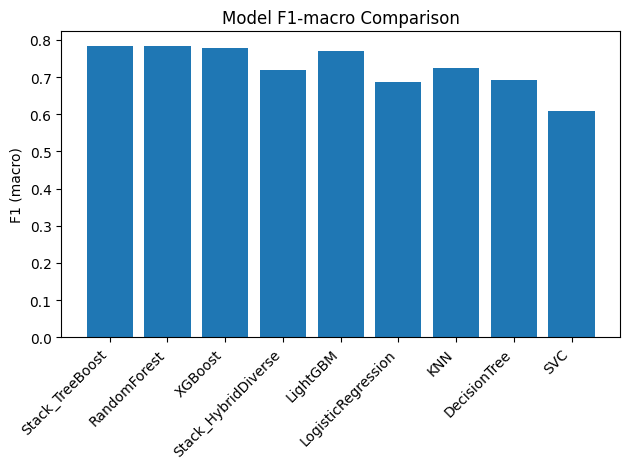

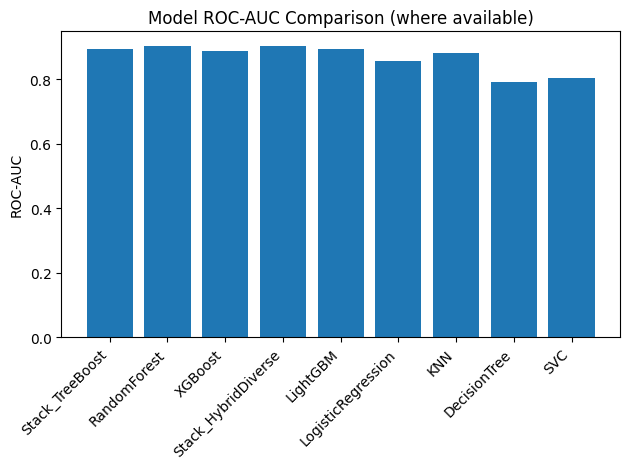

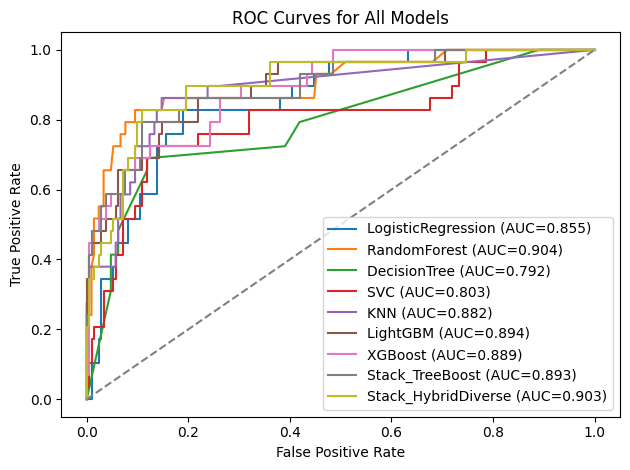

In [20]:
# Prepare comparison table
display(df_res)


# Bar chart for metrics
# Accuracy
plt.figure()
plt.bar(df_res['name'], df_res['accuracy'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.tight_layout()
plt.show()

# Precision
plt.figure()
plt.bar(df_res['name'], df_res['precision'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Precision')
plt.title('Model Precision Comparison')
plt.tight_layout()
plt.show()

# Recall
plt.figure()
plt.bar(df_res['name'], df_res['recall'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Recall')
plt.title('Model Recall Comparison')
plt.tight_layout()
plt.show()

# F1-score
plt.figure()
plt.bar(df_res['name'], df_res['f1'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('F1 (macro)')
plt.title('Model F1-macro Comparison')
plt.tight_layout()
plt.show()

# ROC-AUC
plt.figure()
valid_roc = df_res[~df_res['roc_auc'].isna()]
plt.bar(valid_roc['name'], valid_roc['roc_auc'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('ROC-AUC')
plt.title('Model ROC-AUC Comparison (where available)')
plt.tight_layout()
plt.show()

# --- ROC Curves for All Models ---
plt.figure()
for r in results:
    if r['y_prob'] is not None:
        fpr, tpr, _ = roc_curve(y_test, r['y_prob'])
        plt.plot(fpr, tpr, label=f"{r['name']} (AUC={r['roc_auc']:.3f})")

plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## 8. Feature Importance (example)

Show feature importance for RandomForest and XGBoost.


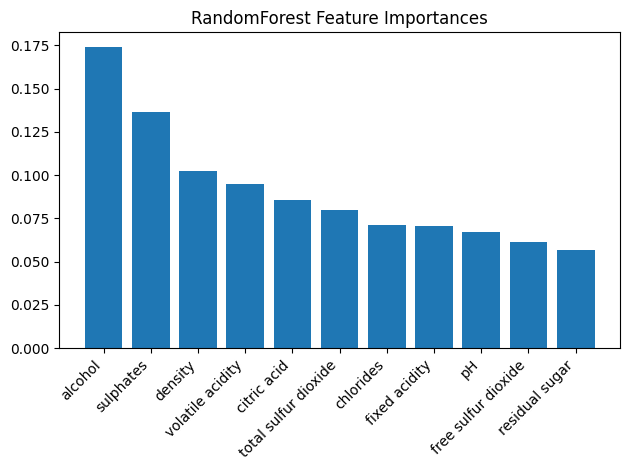

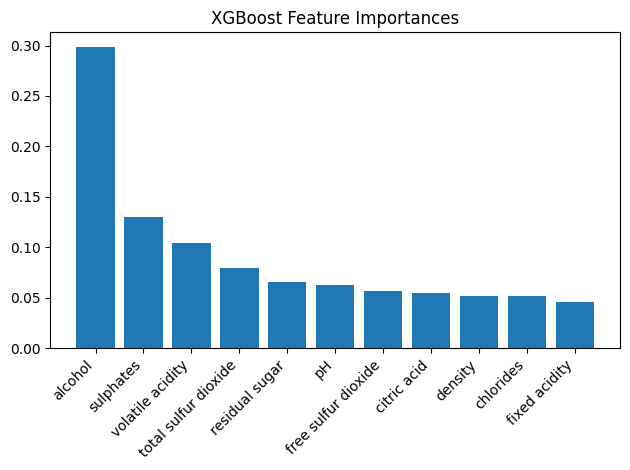

In [21]:
# Feature importance
fi_plots = 0
if any(r['name']=='RandomForest' for r in results):
    rf = next((r['model'] for r in results if r['name']=='RandomForest'), None)
    if rf is not None and hasattr(rf, 'feature_importances_'):
        imp = rf.feature_importances_
        idx = np.argsort(imp)[::-1]
        names = X.columns[idx]
        import matplotlib.pyplot as plt
        plt.figure()
        plt.bar(names, imp[idx])
        plt.title('RandomForest Feature Importances')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        fi_plots += 1

if any(r['name']=='XGBoost' for r in results):
    lgbm = next((r['model'] for r in results if r['name']=='XGBoost'), None)
    if lgbm is not None and hasattr(lgbm, 'feature_importances_'):
        imp = lgbm.feature_importances_
        idx = np.argsort(imp)[::-1]
        names = X.columns[idx]
        import matplotlib.pyplot as plt
        plt.figure()
        plt.bar(names, imp[idx])
        plt.title('XGBoost Feature Importances')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        fi_plots += 1

if fi_plots == 0:
    print('No fitted tree-based model with feature_importances_ found to plot.')


## 9. Conclusion and Next Steps

The experimental results show that **Stack A (Tree/Boosting Stack)** achieved slightly better performance than **Stack B (Hybrid Diverse Stack)** across all key metrics:

| Model                   |  Accuracy  | F1 (macro) |   ROC-AUC  |
| :---------------------- | :--------: | :--------: | :--------: |
| **Stack A (TreeBoost)** | **0.924686** | **0.783514** | **0.892775** |
| Stack B (HybridDiverse)    |   0.912134   |   0.719875   |   0.902791   |

### 9.1. Key Observations
1. **Stack A** performs slightly better overall and maintains a balanced trade-off among all metrics.

2. However, **RandomForest** alone remains the strongest single model, showing the best ROC-AUC and comparable F1. This is likely because:

* RandomForest inherently performs internal ensembling (bagging of decision trees), which already captures diverse decision boundaries and minimizes overfitting.

* The dataset's moderate size and purely numerical features favor tree-based splits, allowing RandomForest to exploit feature thresholds efficiently.

* Stacking tree-based models (as in Stack A) introduces correlation between base learners, which limits further performance gains.

### 9.2. Conclusion

1. Ensemble stacking improved overall robustness but did not significantly outperform RandomForest due to high redundancy among tree-based models.

2. Stack A remains more stable and generalizes better than Stack B, especially for non-linear, continuous data.

3. For this dataset, RandomForest or Stack A are optimal trade-offs between accuracy and interpretability.

### 9.3. Next Steps

1. Apply **cross-validated stacking (out-of-fold meta training)** to reduce data leakage and improve meta-learner generalization.
2. Explore **soft voting ensembles** among `RandomForest`, `XGBoost`, and `LightGBM` to combine strengths while reducing correlation.
3. Perform **hyperparameter optimization** (e.g., `max_depth`, `learning_rate`, `n_estimators`) for top models to further improve AUC.
4. Test feature importance and SHAP analysis to interpret why tree-based methods dominate on this dataset.

